In [5]:
import numpy as np
import nat_asd_utils

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## load good subjects

In [3]:
with open('good_pilots_ru_dm_list.txt', 'r') as file:
    sub_list = file.readlines()
good_subjects_list = [line.strip() for line in sub_list]

good_subjects_list

['NDARHJ830RXD',
 'NDARVB897AH1',
 'NDARFA402LMW',
 'NDARUX340FYC',
 'NDARJG687YYX',
 'NDARVD194JX2',
 'NDARVR601FUT',
 'NDARUL694GYN']

In [3]:
def load_video_features(stim,all_layers):
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    save_path = f'../data/{stim}_frames_resnet50/'
    #print('ResNet50 frame embeddings')
    # for emb_f in emb_list:
    #     emb = np.load(f'{emb_f}')
    #     print(emb['frame_0000.jpg'].shape, os.path.splitext(os.path.basename(emb_f))[0])
    X=[]
    for layer in all_layers:
        X_layer=[]
        emb = np.load(f'{save_path}{layer}.npz')
        for k in list(emb.keys()):
            X_layer.append(emb[k].flatten())
        #X.append(  transformer.fit_transform(  np.array(X_layer)[:(-1*delay),:]  )  )
        X.append(  np.array(X_layer)  )

    return(X)

In [4]:
all_layers=['relu','maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']
stim='DM'
X=load_video_features(stim,all_layers)

In [9]:
# X=nat_asd_utils.apply_pca(X,50)


KeyboardInterrupt



In [5]:
X[0].shape

(750, 802816)

## how many components do we need to get 95 % variance explained?

In [6]:
def compute_pca_components(arrays, variance_threshold=0.95):
    from sklearn.decomposition import PCA
    component_counts = []
    for array in arrays:
        pca = PCA()
        pca.fit(array)
        explained_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components = np.argmax(explained_variance >= variance_threshold) + 1
        component_counts.append(num_components)
    return component_counts

In [7]:
compute_pca_components(X, variance_threshold=0.95)

[412, 374, 484, 470, 451, 400, 149]

So i should maybe go up to ~500 components here!
lets pre-compute these features since it is computational expensive to do on the fly

In [12]:
import h5py
for n_components in [1,5,10,50,100,200,500]:
    print(n_components)
    Xi=nat_asd_utils.apply_pca(X, n_components)
    with h5py.File(f'../data/features/DM_resnet50_activations-PCA-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=Xi[i])

1
5
10
50
100
200
500


In [5]:
import pilot
X,features=pilot.load_features('resnet50pca10hrf')

In [6]:
X[0].shape

(750, 10)

In [8]:
%run pilot.py -s NDARHJ830RXD -p earlyvisual -f resnet50pca1hrf -d 0

running subject NDARHJ830RXD
loaded parcels ['V1', 'V2', 'V3', 'V4', 'MT']
loaded brain data
No value was passed to args.bootstrap
starting regression
125.59460544586182
saving results


In [18]:
r2_lists_lists=[]
for pca in [1,5,10,50,100,200,500]:
    r2_lists=[]
    for s in good_subjects_list:
        loaded=np.load(f'../good_pilots/sub-{s}_roi-earlyvisual_feat-resnet50pca{pca}hrf_delay-0.npz')
        r2_lists.append(np.mean(loaded['stacked_r2s']))
    r2_lists_lists.append(r2_lists)
    print(r2_lists)
    print(np.mean(r2_lists))

[0.00307993430884729, -0.006485519564352007, 0.01283057601923735, -0.009607699108640622, -0.006257393917160835, -0.001760960252480741, -0.0012979488205965425, -0.0015619855929052352]
-0.001382624616006418
[-0.007021770279955009, -0.023796815962915493, 0.0008050194297735327, -0.02167380061513446, -0.020288807572261786, -0.012366729629417483, -0.016054731986007546, -0.006829299568410065]
-0.013403367023041039
[-0.013232568439379361, -0.020246483607460584, -0.008234826631946135, -0.01397209712839221, -0.022871293543004333, -0.011543957123762104, -0.02355937683564627, -0.012856990526445443]
-0.015814699229504556
[-0.01881174699970821, -0.003653760284758808, -0.01563307756264221, -0.03825222638211195, -0.01956726898686301, -0.010823422779563363, -0.022273163261173425, -0.01723956328068463]
-0.0182817786921882
[-0.02293163648828638, -0.020349986420966172, -0.013368368913993291, -0.02388497159882509, -0.0014994153879225158, -0.0050186548177541005, -0.020918437744867305, -0.019274217524466977]

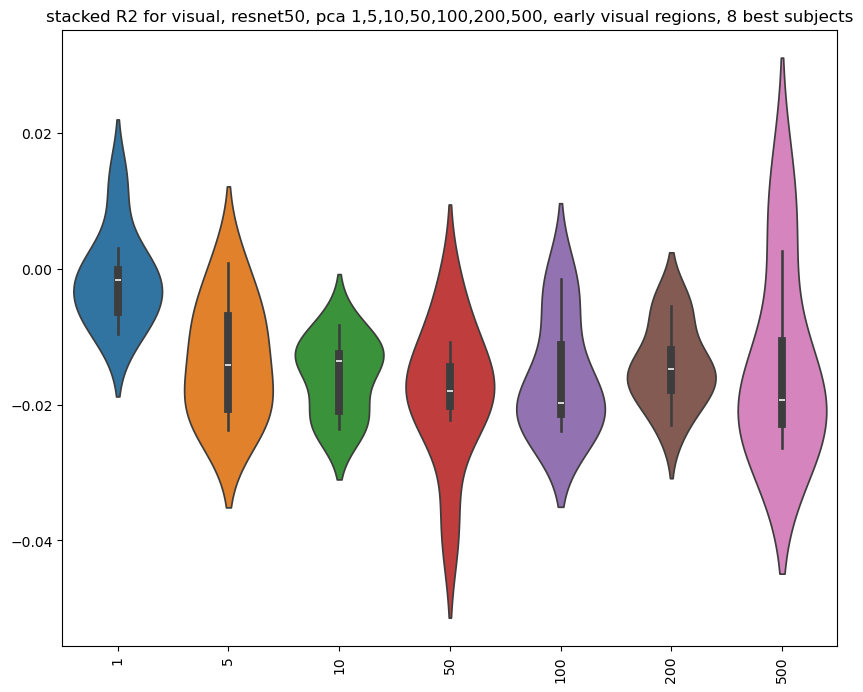

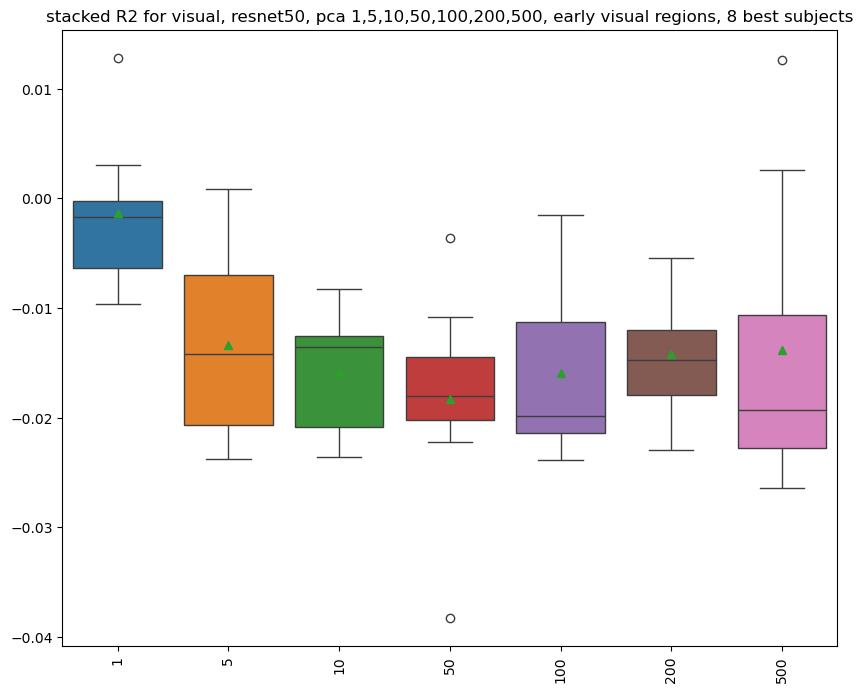

In [29]:
data=np.array(r2_lists_lists).T
import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize=(10,8))
ax=sns.violinplot(data=data)
plt.title(f'stacked R2 for visual, resnet50, pca 1,5,10,50,100,200,500, early visual regions, 8 best subjects')

# # Add 'stacked' to the end of your features list
labels = [1,5,10,50,100,200,500]

# Set the xticklabels of your plot
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels,rotation=90)
plt.show()


# plt.figure(figsize=(20,8))
# ax=sns.boxplot(data=plot_data,showmeans=True)
# plt.title(f'stacked R2 for each feature set, auditory regions, 8 best subjects')



plt.figure(figsize=(10,8))
ax=sns.boxplot(data=data,showmeans=True)
plt.title(f'stacked R2 for visual, resnet50, pca 1,5,10,50,100,200,500, early visual regions, 8 best subjects')


# # Add 'stacked' to the end of your features list
labels = [1,5,10,50,100,200,500]

# Set the xticklabels of your plot
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels,rotation=90)
plt.show()

### it still seems liek 1 pca component does the best... what??